<a href="https://colab.research.google.com/github/ArcherOO7/GDG-Project/blob/main/LLM_Finance_Project_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langchain-groq langchain-community yfinance requests newsapi-python PyMuPDF faiss-cpu sentence-transformers scikit-learn matplotlib statsmodels

API Keys loaded successfully.

--- Generating Ensemble Forecast for Apple Inc. (AAPL) ---
ARIMA model successful.
ETS model successful.
RandomForest_50 model successful.
RandomForest_100 model successful.
GradientBoosting model successful.


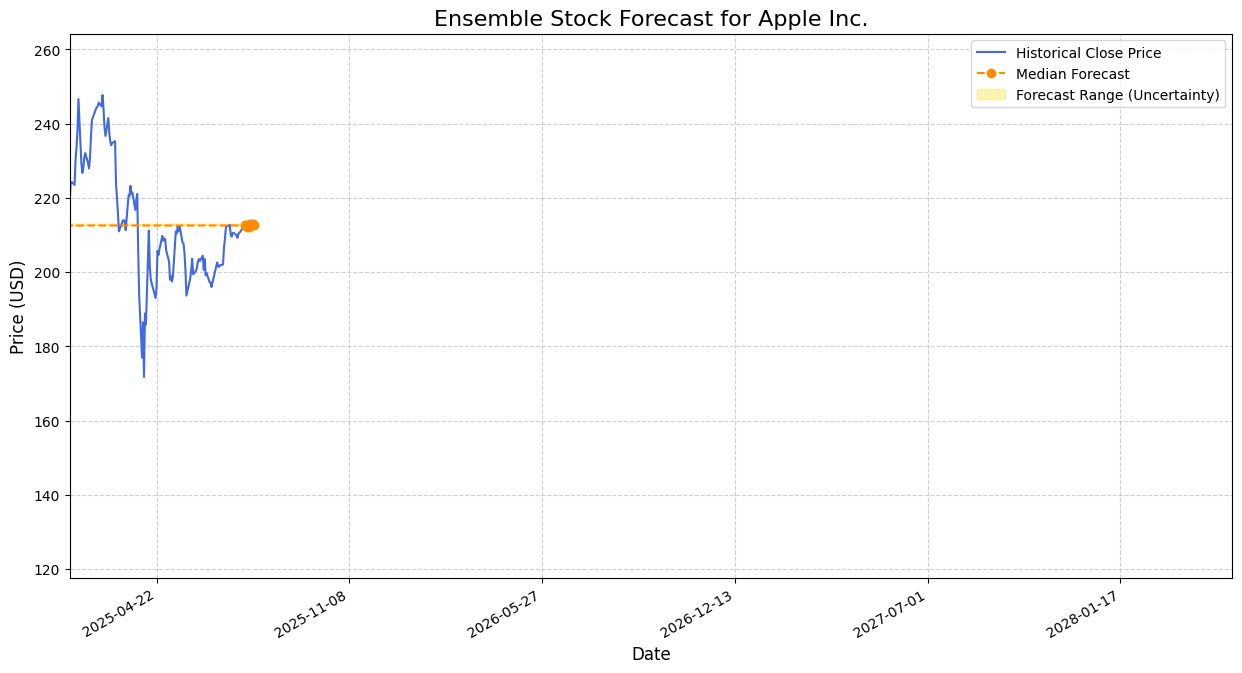


🤖 --- LLM Qualitative Analysis of Ensemble Forecast ---
**Assessment of the Overall Forecast Range:**

The ensemble of models provides a relatively narrow forecast range of $211.26 to $212.90, indicating a high degree of consensus among the models. This suggests that the market is expected to remain stable or experience a moderate increase over the next 10 days. The median forecast price of $212.77 is also relatively close to the current market price, indicating a moderate upward trend.

**Alignment with Current News and Financial Sentiment:**

Upon reviewing the latest news headlines, I notice that Apple's stock has been trending positively, with Jim Cramer's "Got Game" comment and the S&P 500 hitting all-time highs. The news about AWS' agentic push and the cloud wars to come may also have a positive impact on Apple's stock, as the company is a major player in the tech industry. Given this context, I believe that the RandomForest_100 model's forecast of $211.26 seems most aligned wit

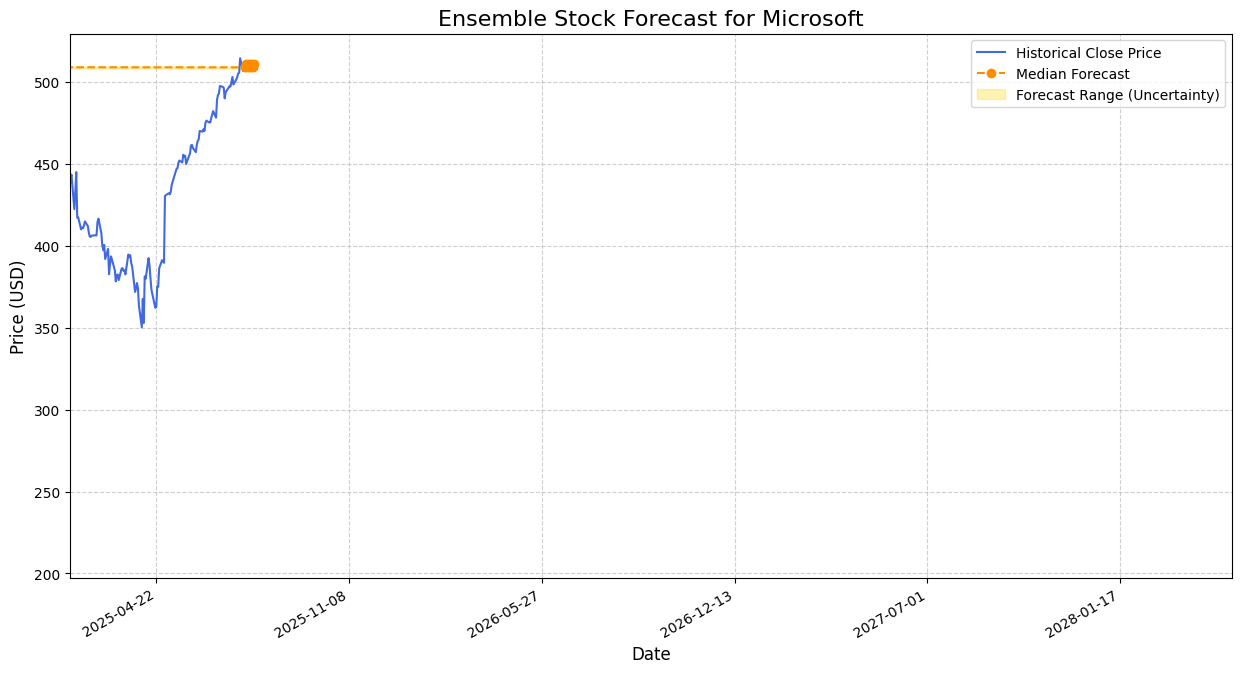


🤖 --- LLM Qualitative Analysis of Ensemble Forecast ---
**Assessment of the Forecast Range:**
The ensemble of models provides a relatively narrow forecast range of $510.52 to $511.25, indicating a high degree of consensus among the models. This suggests that the market is expected to remain stable and range-bound over the next 10 days, with minimal volatility.

**Alignment with Current News and Financial Sentiment:**
Upon reviewing the latest news headlines, I notice that the news is mixed, with some positive developments (e.g., NXP Semiconductors' better-than-expected sales) and some negative ones (e.g., the Microsoft cyberattack). However, the overall sentiment appears to be neutral, with no major catalysts driving significant price movements.

Among the individual models, the RandomForest_50 and RandomForest_100 forecasts ($511.25 and $510.99, respectively) seem most aligned with the current news and financial sentiment. These models are both machine learning-based and have been tr

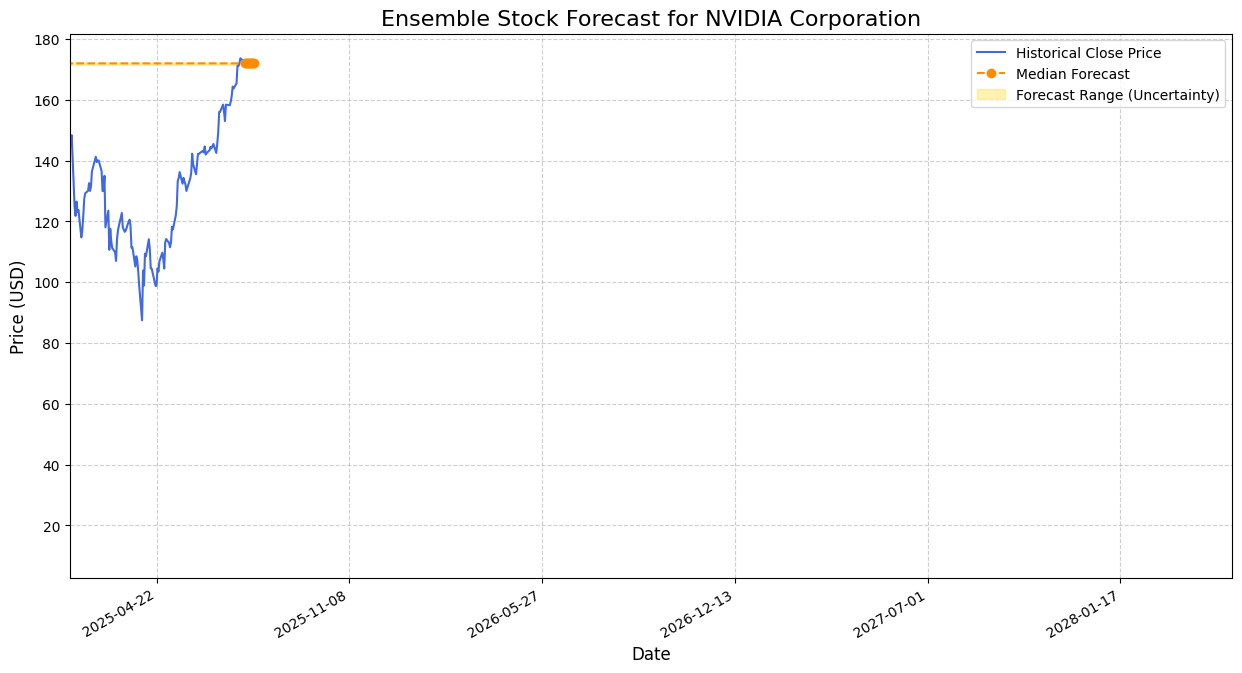


🤖 --- LLM Qualitative Analysis of Ensemble Forecast ---
**Overall Forecast Range Assessment:**
The ensemble of models provides a relatively narrow forecast range of $171.34 to $172.23, indicating a high degree of consensus among the models. This suggests that the market is expected to remain stable or experience a moderate increase over the next 10 days. The median forecast price of $172.19 is also within this range, indicating a balanced view among the models.

**Individual Model Forecasts:**
Upon examining the individual model forecasts, I notice that the RandomForest models (50 and 100) are the most optimistic, predicting prices above the median forecast. The ARIMA model is the most conservative, predicting a price slightly below the median. The ETS model is the most extreme, predicting a price above the median. The GradientBoosting model is the most pessimistic, predicting a price below the median.

**Alignment with Current News and Financial Sentiment:**
Based on the latest news 

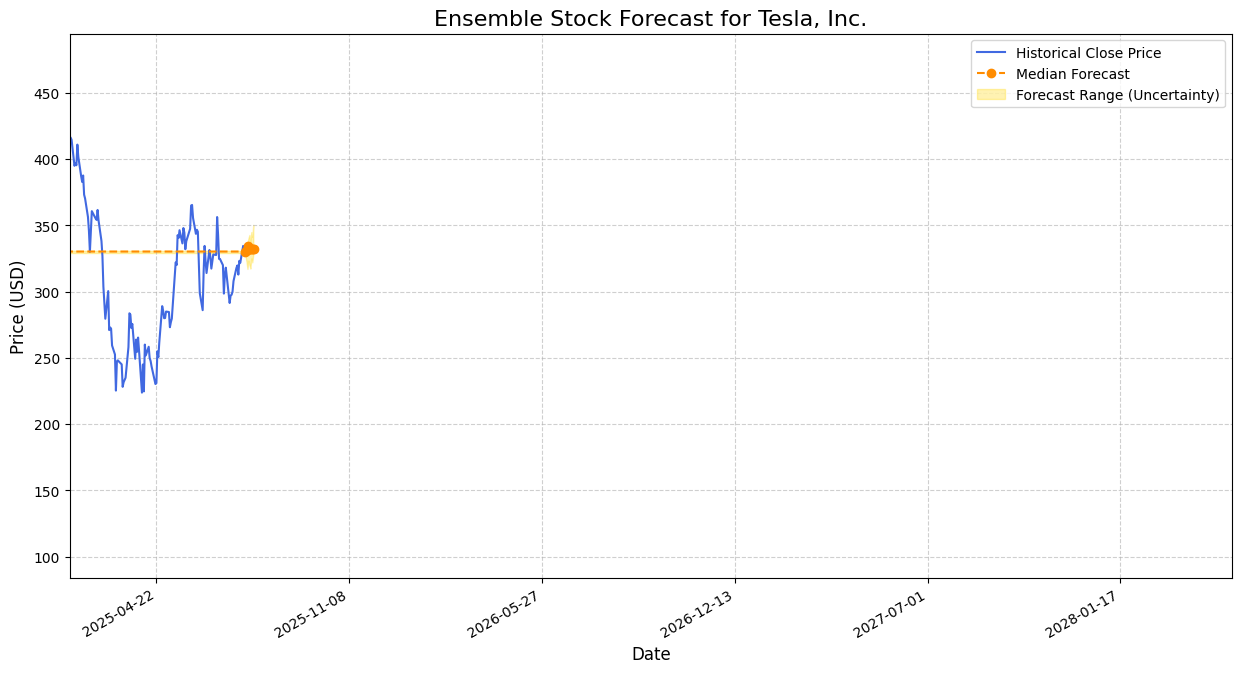


🤖 --- LLM Qualitative Analysis of Ensemble Forecast ---
**Assessment of the Forecast Range:**

The ensemble of models provides a relatively narrow forecast range of $327.35 to $349.86, with a median forecast price of $332.27. This suggests a high degree of consensus among the models, indicating a relatively stable outlook for Tesla's stock price over the next 10 days. The range is also relatively tight, implying that the models are not predicting a significant price swing.

**Alignment with Current News and Financial Sentiment:**

Upon reviewing the latest news headlines, I notice that the market is experiencing a positive sentiment, with the S&P 500 and Nasdaq 100 hitting all-time highs. The news headlines highlight favorable corporate news, lower bond yields, and a positive outlook for tech earnings. Given this context, I believe that the RandomForest_100 model's forecast of $327.35 seems most aligned with the current news and financial sentiment. This model's forecast is at the low

In [21]:
import os
import requests
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import traceback
from warnings import filterwarnings

# Import models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from statsmodels.tsa.api import ExponentialSmoothing, ARIMA

# For Colab secrets
from google.colab import userdata

# LangChain components
from langchain_groq import ChatGroq

# Suppress warnings
filterwarnings('ignore')

# ==============================================================================
# SECTION 1: CONFIGURATION
# ==============================================================================
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    FMP_API_KEY = userdata.get('FINANCIAL_MODELING_PREP_API_KEY')
    NEWS_API_KEY = userdata.get('NEWS_API_KEY')
    os.environ["GROQ_API_KEY"] = GROQ_API_KEY
    print("API Keys loaded successfully.")
except Exception as e:
    print(f"Error loading API keys: {e}")

# ==============================================================================
# SECTION 2: DATA FETCHER FUNCTIONS
# ==============================================================================
def get_financial_ratios(ticker_symbol: str) -> str:
    """Fetches key financial ratios from Financial Modeling Prep."""
    if not FMP_API_KEY: return "FMP API key not configured.\n"
    try:
        url = f"https://financialmodelingprep.com/api/v3/ratios-ttm/{ticker_symbol}?apikey={FMP_API_KEY}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        ratios = response.json()
        if not ratios: return "No financial ratios found.\n"
        pe_ratio = ratios[0].get('peRatioTTM', 'N/A')
        return f"Key Financial Ratio (TTM): P/E Ratio: {pe_ratio}\n"
    except Exception as e: return f"Error fetching financial ratios: {e}\n"

def get_latest_news(query: str) -> str:
    """Fetches recent news articles from NewsAPI."""
    if not NEWS_API_KEY: return "News API key not configured.\n"
    try:
        url = f"https://newsapi.org/v2/everything?q={query}&language=en&sortBy=publishedAt&pageSize=5&apiKey={NEWS_API_KEY}"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        articles = response.json().get('articles', [])
        if not articles: return "No recent news found.\n"
        return "Latest News Headlines:\n" + "".join(f"- {article['title']}\n" for article in articles)
    except Exception as e: return f"Error fetching news: {e}\n"

# ==============================================================================
# SECTION 3: ENSEMBLE PREDICTION AND PLOTTING
# ==============================================================================
def predict_with_ensemble(ticker: str, company_name: str, llm):
    """
    Generates an ensemble of forecasts, plots the results, and provides LLM analysis.
    """
    print(f"\n--- Generating Ensemble Forecast for {company_name} ({ticker}) ---")
    try:
        data = yf.download(ticker, period="3y", progress=False)
        if data.empty:
            print(f"Could not download data for {ticker}.")
            return

        close_prices_series = data.iloc[:, 3].copy()
        close_prices_series.dropna(inplace=True)
        if close_prices_series.empty:
            print(f"No valid 'Close' price data found for {ticker}.")
            return

        forecast_horizon = 10
        all_forecasts = {}

        # --- Statistical Models ---
        try:
            model_arima = ARIMA(close_prices_series, order=(5, 1, 0)).fit()
            all_forecasts['ARIMA'] = model_arima.forecast(steps=forecast_horizon)
            print("ARIMA model successful.")
        except Exception as e: print(f"ARIMA model failed: {e}")

        try:
            model_ets = ExponentialSmoothing(close_prices_series, trend="add", seasonal=None).fit()
            all_forecasts['ETS'] = model_ets.forecast(steps=forecast_horizon)
            print("ETS model successful.")
        except Exception as e: print(f"ETS model failed: {e}")

        # --- Machine Learning Models ---
        df_ml = close_prices_series.to_frame(name='Close')
        df_ml['Lag1'] = df_ml['Close'].shift(1)
        df_ml['MA7'] = df_ml['Close'].rolling(7).mean()
        df_ml.dropna(inplace=True)
        X, y = df_ml[['Lag1', 'MA7']], df_ml['Close']

        ml_models = {
            "RandomForest_50": RandomForestRegressor(n_estimators=50, random_state=42),
            "RandomForest_100": RandomForestRegressor(n_estimators=100, random_state=42),
            "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
        }

        for name, model in ml_models.items():
            try:
                model.fit(X, y)
                last_7_prices = list(df_ml['Close'][-7:])
                current_lag = df_ml['Close'].iloc[-1]
                preds = []
                for _ in range(forecast_horizon):
                    current_ma = np.mean(last_7_prices)
                    pred = model.predict(pd.DataFrame([[current_lag, current_ma]], columns=['Lag1', 'MA7']))[0]
                    preds.append(pred)
                    current_lag = pred
                    last_7_prices.pop(0)
                    last_7_prices.append(pred)

                future_dates = pd.date_range(start=close_prices_series.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
                all_forecasts[name] = pd.Series(preds, index=future_dates)
                print(f"{name} model successful.")
            except Exception as e:
                print(f"{name} model failed: {e}")

        if not all_forecasts:
            print("All models failed to produce a forecast.")
            return

        # Aggregate Forecasts
        forecast_df = pd.concat(all_forecasts.values(), axis=1)
        median_forecast = forecast_df.median(axis=1)
        min_forecast = forecast_df.min(axis=1)
        max_forecast = forecast_df.max(axis=1)

        # Plot the Ensemble Forecast
        plt.figure(figsize=(15, 8))

        # --- FINAL PLOTTING FIX ---
        # Convert all date indexes to matplotlib's numerical date format BEFORE plotting
        hist_dates_num = mdates.date2num(close_prices_series.index)
        forecast_dates_num = mdates.date2num(median_forecast.index)

        # Plot using the numerical dates
        plt.plot(hist_dates_num, close_prices_series, label="Historical Close Price", color='royalblue')
        plt.plot(forecast_dates_num, median_forecast, label="Median Forecast", color='darkorange', marker='o', linestyle='--')
        plt.fill_between(forecast_dates_num, min_forecast, max_forecast, color='gold', alpha=0.3, label="Forecast Range (Uncertainty)")

        # Get the current axes and set the x-axis to display dates, not numbers
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

        # Set the x-axis view to the last 6 months
        start_date_limit = close_prices_series.index[-1] - pd.DateOffset(months=6)
        ax.set_xlim(left=mdates.date2num(start_date_limit))

        plt.gcf().autofmt_xdate() # Auto-format the dates for readability
        # --- END OF FINAL FIX ---

        plt.title(f'Ensemble Stock Forecast for {company_name}', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price (USD)', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

        # Use LLM for Qualitative Analysis
        print("\n🤖 --- LLM Qualitative Analysis of Ensemble Forecast ---")
        news = get_latest_news(f"{company_name} stock")
        ratios = get_financial_ratios(ticker)

        forecast_summary = (
            f"The ensemble of models provides a median 10-day forecast price of ${median_forecast.iloc[-1]:.2f}. "
            f"The full forecast range is between ${min_forecast.iloc[-1]:.2f} and ${max_forecast.iloc[-1]:.2f}."
        )

        individual_forecasts_str = "Individual Model Forecasts (10-day end price):\n"
        for name, forecast in all_forecasts.items():
            individual_forecasts_str += f"- {name}: ${forecast.iloc[-1]:.2f}\n"

        llm_prompt = (
            f"You are a professional financial analyst. Based on the following data, provide a qualitative "
            f"assessment of the provided 10-day stock forecast.\n\n"
            f"**Company:** {company_name} ({ticker})\n"
            f"**Quantitative Summary:** {forecast_summary}\n\n"
            f"**{individual_forecasts_str}**\n"
            f"**Contextual Data:**\n{ratios}{news}\n"
            f"**Your Task:** First, assess the overall forecast range. Then, comment on which individual model's forecast "
            f"(e.g., ARIMA, RandomForest) seems most aligned with the current news and financial sentiment. "
            f"Conclude with the key factors to watch."
        )

        llm_response = llm.invoke(llm_prompt)
        response_text = llm_response.content if hasattr(llm_response, 'content') else str(llm_response)

        print(response_text)
        print("-------------------------------------------------------\n")

    except Exception as e:
        print(f"An error occurred during the ensemble process for {ticker}: {e}")
        traceback.print_exc()

# ==============================================================================
# SECTION 4: MAIN EXECUTION BLOCK
# ==============================================================================
llm = ChatGroq(temperature=0.2, model_name="llama3-8b-8192")

stocks_to_analyze = [
    ("AAPL", "Apple Inc."),
    ("MSFT", "Microsoft"),
    ("NVDA", "NVIDIA Corporation"),
    ("TSLA", "Tesla, Inc."),
]

for ticker, name in stocks_to_analyze:
    predict_with_ensemble(ticker, name, llm)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_and_print_accuracy(ticker: str, company_name: str):
    """
    Performs a backtest on historical data to evaluate the accuracy of each model.
    """
    print(f"\n--- Calculating Model Accuracy for {company_name} ({ticker}) ---")
    try:
        # 1. Fetch and prepare data
        data = yf.download(ticker, period="3y", progress=False)
        if data.empty:
            print(f"Could not download data for {ticker}.")
            return

        close_prices_series = data.iloc[:, 3].copy()
        close_prices_series.dropna(inplace=True)
        if len(close_prices_series) < 60: # Need enough data for train/test
             print(f"Not enough historical data to test {ticker}.")
             return

        # 2. Split data into training and testing sets
        train_data = close_prices_series[:-30]
        test_data = close_prices_series[-30:]

        accuracy_scores = {}

        # --- Backtest Statistical Models ---
        try:
            model_arima = ARIMA(train_data, order=(5, 1, 0)).fit()
            predictions_arima = model_arima.forecast(steps=len(test_data))
            accuracy_scores['ARIMA'] = {
                "MAE": mean_absolute_error(test_data, predictions_arima),
                "RMSE": np.sqrt(mean_squared_error(test_data, predictions_arima)),
                "MAPE": np.mean(np.abs((test_data - predictions_arima) / test_data)) * 100
            }
            print("ARIMA backtest successful.")
        except Exception as e: print(f"ARIMA backtest failed: {e}")

        try:
            model_ets = ExponentialSmoothing(train_data, trend="add", seasonal=None).fit()
            predictions_ets = model_ets.forecast(steps=len(test_data))
            accuracy_scores['ETS'] = {
                "MAE": mean_absolute_error(test_data, predictions_ets),
                "RMSE": np.sqrt(mean_squared_error(test_data, predictions_ets)),
                "MAPE": np.mean(np.abs((test_data - predictions_ets) / test_data)) * 100
            }
            print("ETS backtest successful.")
        except Exception as e: print(f"ETS backtest failed: {e}")

        # --- Backtest Machine Learning Models ---
        df_ml = close_prices_series.to_frame(name='Close')
        df_ml['Lag1'] = df_ml['Close'].shift(1)
        df_ml['MA7'] = df_ml['Close'].rolling(7).mean()
        df_ml.dropna(inplace=True)

        train_ml = df_ml[:-30]
        test_ml = df_ml[-30:]

        X_train, y_train = train_ml[['Lag1', 'MA7']], train_ml['Close']
        X_test, y_test = test_ml[['Lag1', 'MA7']], test_ml['Close']

        ml_models = {
            "RandomForest_50": RandomForestRegressor(n_estimators=50, random_state=42),
            "RandomForest_100": RandomForestRegressor(n_estimators=100, random_state=42),
            "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
        }

        for name, model in ml_models.items():
            try:
                model.fit(X_train, y_train)
                predictions_ml = model.predict(X_test)
                accuracy_scores[name] = {
                    "MAE": mean_absolute_error(y_test, predictions_ml),
                    "RMSE": np.sqrt(mean_squared_error(y_test, predictions_ml)),
                    "MAPE": np.mean(np.abs((y_test - predictions_ml) / y_test)) * 100
                }
                print(f"{name} backtest successful.")
            except Exception as e: print(f"{name} backtest failed: {e}")

        # 3. Format and print the results
        if not accuracy_scores:
            print("No models were successfully backtested.")
            return

        results_df = pd.DataFrame(accuracy_scores).T
        print("\n--- Model Accuracy Scores ---")
        print(f"Lower values are better for all metrics.")
        print(f"MAE/RMSE are in USD, MAPE is in %.")
        print(results_df.round(3))
        print("-----------------------------\n")

    except Exception as e:
        print(f"An error occurred during the accuracy calculation for {ticker}: {e}")
        traceback.print_exc()

In [23]:
for ticker, name in stocks_to_analyze:
    calculate_and_print_accuracy(ticker, name)


--- Calculating Model Accuracy for Apple Inc. (AAPL) ---
ARIMA backtest successful.
ETS backtest successful.
RandomForest_50 backtest successful.
RandomForest_100 backtest successful.
GradientBoosting backtest successful.

--- Model Accuracy Scores ---
Lower values are better for all metrics.
MAE/RMSE are in USD, MAPE is in %.
                    MAE   RMSE   MAPE
ARIMA             5.162  6.041    NaN
ETS               4.577  5.072    NaN
RandomForest_50   2.033  2.621  0.992
RandomForest_100  2.077  2.688  1.014
GradientBoosting  1.531  2.014  0.749
-----------------------------


--- Calculating Model Accuracy for Microsoft (MSFT) ---
ARIMA backtest successful.
ETS backtest successful.
RandomForest_50 backtest successful.
RandomForest_100 backtest successful.
GradientBoosting backtest successful.

--- Model Accuracy Scores ---
Lower values are better for all metrics.
MAE/RMSE are in USD, MAPE is in %.
                     MAE    RMSE   MAPE
ARIMA             21.502  25.062    NaN
ET